# Define the system  

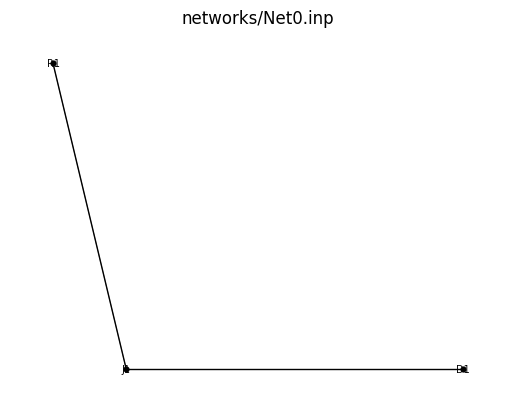

<Axes: title={'center': 'networks/Net0.inp'}>

In [1]:
import wntr
import wntr_quantum

# Create a water network model
inp_file = 'networks/Net0.inp'
# inp_file = 'networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original simulator

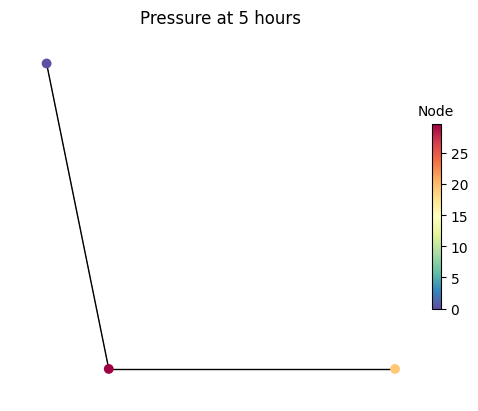

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
# define the classical simulator
sim = wntr.sim.EpanetSimulator(wn)

# run the simulation
results = sim.run_sim()

# Plot results on the network
pressure_at_5hr_ref = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr_ref, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

## Run with the VQLS solver

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so


100%|██████████| 4/4 [00:00<00:00, 2144.33it/s]


Solving the linear system Ax = b with:
A =  [[ 0.1155474 -0.1155474]
 [-0.1155474  2.454284 ]]
b =  [ -1.614401 230.2773  ]
x =  [83.86535743 97.77506359]
residue =  0.007170794164091991


100%|██████████| 4/4 [00:00<00:00, 1718.45it/s]


Solving the linear system Ax = b with:
A =  [[ 0.02725884 -0.02725884]
 [-0.02725884  0.8429599 ]]
b =  [-0.937234 80.27994 ]
x =  [62.96098623 97.27177571]
residue =  0.0019618124982938535


100%|██████████| 4/4 [00:00<00:00, 1852.61it/s]


Solving the linear system Ax = b with:
A =  [[ 0.02718497 -0.02718497]
 [-0.02718497  0.8407163 ]]
b =  [-0.9347067 80.06636  ]
x =  [62.51366832 97.2571571 ]
residue =  0.009794674488406764


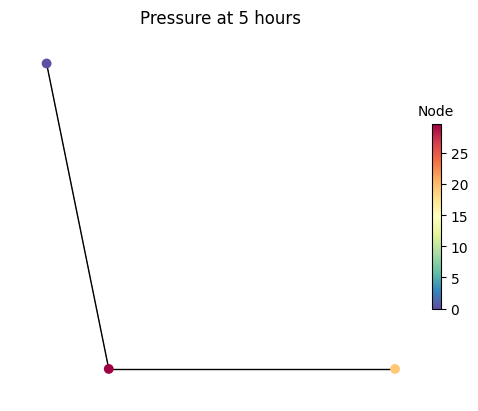

<Axes: title={'center': 'Pressure at 5 hours'}>

In [3]:
from quantum_newton_raphson.vqls_solver import VQLS_SOLVER
from qiskit.primitives import Estimator
from qiskit.circuit.library import RealAmplitudes 
from qiskit_algorithms.optimizers import CG

# define the ansatz
qc = RealAmplitudes(1, reps=3, entanglement='full')

# define the estimator : WARNING This is redefined in vqls_solver becauseof a qiskit bug
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz = qc,
    optimizer = CG(),
    matrix_decomposition = "pauli"
)


# define the quantum epanet simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)

# run the simulation
results = sim.run_sim(linear_solver=linear_solver)

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

## Compare the pressure values obtained

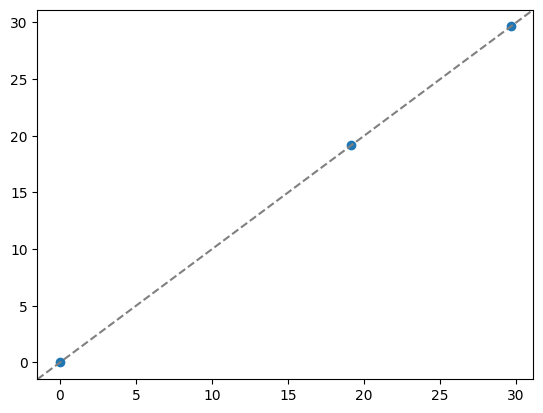

In [4]:
import matplotlib.pyplot as plt 
plt.scatter(pressure_at_5hr_ref.values, pressure_at_5hr.values)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.show()